In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
import os
import copy
import shutil
import random
from skimage import io
from skimage.transform import rescale, resize
import skimage.exposure
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

def random_brightness(image):
  transform = A.RandomBrightnessContrast(p=0.5)
  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])
  return im

def apply_rgbshift(image):
  transform = A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=1)
  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])
  return im

def apply_clahe(image):
  clip_limit=6.0
  tile_grid_size=(16, 16)

  transform = A.CLAHE(clip_limit, tile_grid_size, p=1.0)
  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])
  return im

def apply_rotation(image, mask):
  angle = random.randint(0, 90)
  transform = A.Rotate(limit=[angle, angle], p=1.0, border_mode=cv2.BORDER_CONSTANT)

  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])

  augmentations = transform(image = mask)
  msk = Image.fromarray(augmentations['image'])

  return im, msk

def read_tiff(img_path, resize_ratio=None, resizing = True, normalize=True, printing=True):
  img = io.imread(img_path)
  img_F =img.copy()
  if resize_ratio:
    img_F = rescale(img, resize_ratio, anti_aliasing=True)
  if resizing:
    img_F = resize(img_F, (750,750), anti_aliasing=True)
  
  path_img = os.path.basename(img_path)
  if normalize:
    CHANNELS = range(12)
    img_F = np.dstack([
        skimage.exposure.rescale_intensity(img_F[:,:,c], out_range=(0, 1)) 
        for c in CHANNELS])
  if printing:
    print(f"(origin shape: {path_img}: {img.shape} -> rescale: {str(img_F.shape)}) - Range -> [{img_F.min(), img_F.max()}]")
  return img_F

In [3]:
root = "/home/sebasmos/Desktop/DATASETS/"
code = 23001
baseline = os.path.join(root, "DATASET_improved_10_cities", str(code))
# Path to dataset with improved images
aug_root =  os.path.join(root, "DATASET_augmented",  str(code))
print(f"root: ", root)
print(f"baseline: ", baseline)
print(f"aug_root: ", aug_root)
CLEAN = False
if CLEAN:
    shutil.rmtree(aug_root)
else: 
    try:
        shutil.copytree(baseline, aug_root)
    except:
        pass

root:  /home/sebasmos/Desktop/DATASETS/
baseline:  /home/sebasmos/Desktop/DATASETS/DATASET_improved_10_cities/23001
aug_root:  /home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001


In [4]:
images = sorted(glob.glob(os.path.join(baseline)+"/*.tiff")) # use sorted to align images temporally back-forwards
print(f"Total # images: ", len(images))

Total # images:  165


In [5]:
def augment_satellite_image(path, display=True, resize_ratio=(1, 1, 1)):
        """
        Augment images given image path 
        https://albumentations.ai/docs/getting_started/image_augmentation/?query=RandomBrightnessContrast
        ::param path: image path
        """
        count = 1
        count2 = 1
        count3 = 1
        image_name = path.split("/")[-1][:-5]
        img = (255*read_tiff(path, resize_ratio=resize_ratio, resizing = True, normalize=True, printing=True)).astype("uint8")
        B =img[:,:,1:4][:,:,0]
        G =img[:,:,1:4][:,:,1]
        R =img[:,:,1:4][:,:,2]
        RGB_img = np.stack([R,G,B]).transpose(2,1,0)

        # RGBSHIFT
        if random.random() > 0.5:
            img[:,:,1:4] = np.array(apply_rgbshift(RGB_img))
            aug_path = os.path.join(aug_root, image_name + "_A1_"+str(count)+".tiff")
            print("storing ", aug_path)
            io.imsave(aug_path, img)
            count+=1
        # CLAHE
        if random.random() > 0.5:
            img[:,:,1:4] = np.array(apply_clahe(RGB_img))
            aug_path = os.path.join(aug_root, image_name+ "_A2_"+str(count2)+".tiff")
            print("storing ", aug_path)
            io.imsave(aug_path, img)
            count2+=1
        #random_brightness
        if random.random() > 0.5:
            img[:,:,1:4] = np.array(random_brightness(RGB_img))
            aug_path = os.path.join(aug_root, image_name+ "_A3_"+str(count2)+".tiff")
            print("Image augmented and stored in: ", aug_path)
            io.imsave(aug_path, img)
            count3+=1
        if display:
            plt.figure(figsize=(9, 3))
            print(img[:,:,1:4].shape)
            plt.imshow(RGB_img)
def augment_satellite_replaced_img(path, display=True, resize_ratio=(1, 1, 1)):
        """
        Augment images given image path 
        https://albumentations.ai/docs/getting_started/image_augmentation/?query=RandomBrightnessContrast
        ::param path: image path
        """
        #print("augmenting ", path)
        count = 1
        count2 = 1
        count3 = 1
        image_name = path.split("/")[-1][:-5]
        img = (255*read_tiff(path, resize_ratio=resize_ratio, resizing = True, normalize=True, printing=True)).astype("uint8")
        B =img[:,:,1:4][:,:,0]
        G =img[:,:,1:4][:,:,1]
        R =img[:,:,1:4][:,:,2]
        RGB_img = np.stack([R,G,B]).transpose(2,1,0)

        # RGBSHIFT
        if random.random() > 0.5:
            img[:,:,1:4] = np.array(apply_rgbshift(RGB_img))
            print(f"[AUGMENTED] with apply_rgbshift: {image_name}")
            count+=1
            return img
        # CLAHE
        if random.random() > 0.5:
            img[:,:,1:4] = np.array(apply_clahe(RGB_img))
            print(f"[AUGMENTED] with apply_clahe: {image_name}")
            count2+=1
            return img
        #random_brightness
        else: #random.random() > 0.5:
            img[:,:,1:4] = np.array(random_brightness(RGB_img))
            print(f"[AUGMENTED] with random_brightness: {image_name}")
            count3+=1
            return img
        """
        if display:
            plt.figure(figsize=(9, 3))
            print(img[:,:,1:4].shape)
            plt.imshow(RGB_img)
        """

In [6]:
"""
for idx, path in enumerate(images):
    augment_satellite_image(images[idx])
    if idx==3:
        break
"""

'\nfor idx, path in enumerate(images):\n    augment_satellite_image(images[idx])\n    if idx==3:\n        break\n'

### Improving satellite imagery 
Find the closest image sideways under threshold, apply transformation and replace. 

In [7]:
def find_closest_temporal_neighbor(path, images, threshold, resize_ratio = None, resizing = False, normalize = True, printing= False):
    """
    Find the closest temporal neighbor for an image that does not follow np.sum(img)>threshold. The best image is chosen 
    based on the distance calculated by the counters upward and backward, the closest to the current image will be replaced.

    ::param path: current image to be exhanged
    ::param images: list of images in current folder containing collection of possible candidates
    ::param threshold: minimum threshold to choose image. Integer representing the sum of pixels across width/height 

    return  image: the best possible replacement for current image.
    """
    upward = 0
    backward = 0
    current_idx = images.index(path)
    t1 = upward + current_idx 
    t2 = current_idx - backward
    neighborUp = ""
    neighborDown = ""
    img_up = read_tiff(images[t1], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
    img_down = read_tiff(images[t2], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
    # Analize future images and initialize counter
    while t1<=len(images) and np.sum(img_up)<threshold:
        t1+=1
        upward+=1
        img_up = read_tiff(images[t1], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        neighborUp = images[t1]
    # Analize images in the past and initialize counter
    while t2>=0 and np.sum(img_down)<threshold:
        # if index starts off from 0, bound limits
        t2 = int([0 if t2==0 else t2-1][0]) 
        backward+=1
        img_down = read_tiff(images[t2], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        neighborDown = images[t2]
        # If t2 = 0 and np.sum(image[t2])<0 while np.sum(image[t1])>threshold, 
        # choose upward by making backward>upward so upward is taken
        if t2==0 and np.sum(img_down)<=threshold:
            backward=upward+1
            t2=t1
            break
    current = os.path.join(images[current_idx].split("/")[-2:][0], images[current_idx].split("/")[-2:][1])
    f_img = os.path.join(images[t1].split("/")[-2:][0], images[t1].split("/")[-2:][1])
    b_img = os.path.join(images[t2].split("/")[-2:][0], images[t2].split("/")[-2:][1])
    
    if upward<backward :
        img = read_tiff(images[t1], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        assert np.sum(img_up)>=threshold, "image < threshold"
        print(f"-->[FORWARD] - image {current} will be replaced with {f_img} - Temporal distance = [Forward = {upward}, backward = {backward}]")
        return augment_satellite_replaced_img(images[t1])
    elif upward>backward:
        img = read_tiff(images[t2], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        assert np.sum(img_down)>=threshold, "image < threshold"
        print(f"-->[BACKWARDS] - image {current} will be replaced with {b_img} - Temporal distance = [Forward = {upward}, backward = {backward}]")
        return augment_satellite_replaced_img(images[t2])
    elif upward==backward:
        r = [t1 if random.choice(["t1","t2"]) == "t1" else t2][0]
        random_img = os.path.join(images[r].split("/")[-2:][0], images[r].split("/")[-2:][1])
        img = read_tiff(images[r], resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        print(f"-->[EQUIDISTANT] - image {current} will be replaced with {random_img} - Temporal distance = [Forward = {upward} = backward = {backward}]")
        return augment_satellite_replaced_img(images[r])

-->[FORWARD] - image 23001/image_2015-11-01.tiff will be replaced with 23001/image_2016-03-20.tiff - Temporal distance = [Forward = 20, backward = 21]
(origin shape: image_2016-03-20.tiff: (745, 747, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
[AUGMENTED] with apply_rgbshift: image_2016-03-20
[0] Storing augmented image version of 23001/image_2015-11-01.tiff in: /home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001/image_2015-11-01.tiff
(750, 750, 12)
(750, 750, 3)
-->[FORWARD] - image 23001/image_2015-11-08.tiff will be replaced with 23001/image_2016-03-20.tiff - Temporal distance = [Forward = 19, backward = 20]
(origin shape: image_2016-03-20.tiff: (745, 747, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
[AUGMENTED] with apply_rgbshift: image_2016-03-20
[1] Storing augmented image version of 23001/image_2015-11-08.tiff in: /home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001/image_2015-11-08.tiff
(750, 750, 12)
(750, 750, 3)
-->[FORWARD] - image 23001/image

KeyboardInterrupt: 

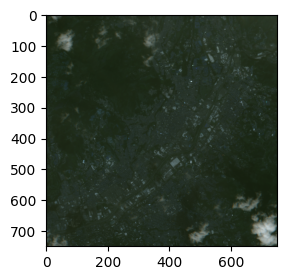

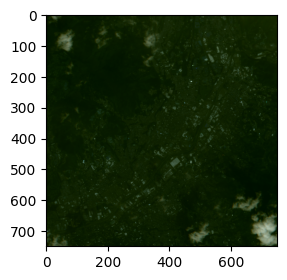

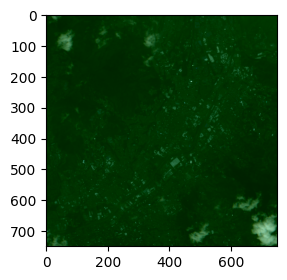

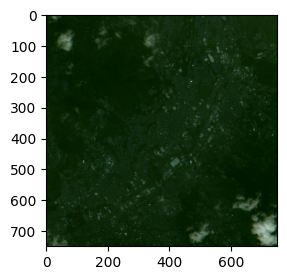

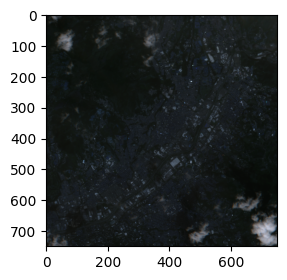

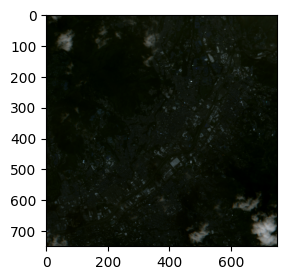

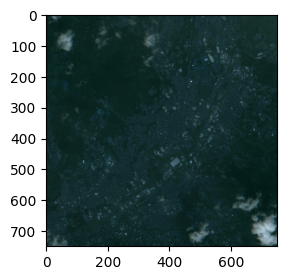

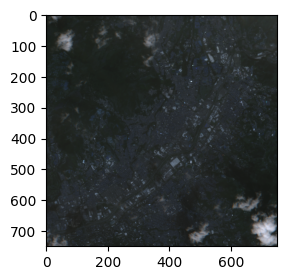

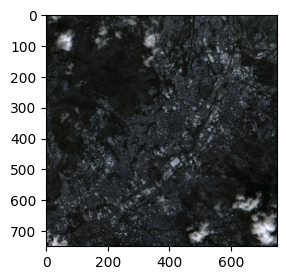

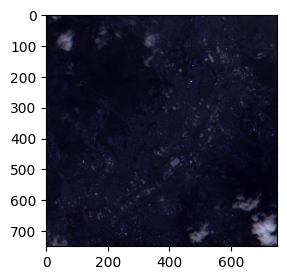

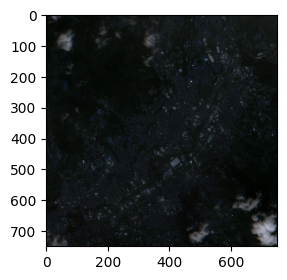

In [8]:
from os.path import exists

resize_ratio=(1, 1, 1)
resize_ratio = None
resizing = False
normalize = True
printing= False
count = 0
threshold = 5
neighbor = ""
for path in images:
    image_name = os.path.join(path.split("/")[-2:][0], path.split("/")[-2:][1])
    img = read_tiff(path, resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
    if np.sum(img)<threshold:
        # if image content is lower than threshold, replace with the "best" image
        img = find_closest_temporal_neighbor(path, images, threshold, resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
        assert np.sum(img)>=threshold, "img is above threshold"
        aug_path = os.path.join(aug_root, path.split("/")[-2:][1])
        print(f"[{count}] Storing augmented image version of {image_name} in: {aug_path}")
        print(img.shape)
        
        if exists(aug_path):
            os.remove(aug_path)
            io.imsave(aug_path, img)
        else: 
            io.imsave(aug_path, img)
        
        if count <=10:    
            plt.figure(figsize=(9, 3))
            print(img[:,:,1:4].shape)
            plt.imshow(img[:,:,1:4])
        
    else:
        print(f"[{count}] - Image {path} ramains unchanged..")
    count+=1
    #if count==5:
    #    break
images = sorted(glob.glob(os.path.join(aug_root)+"/*.tiff")) # use sorted to align images temporally back-forwards
print(f"Total # images: ", len(images))

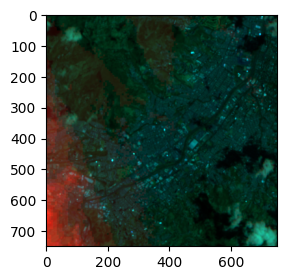

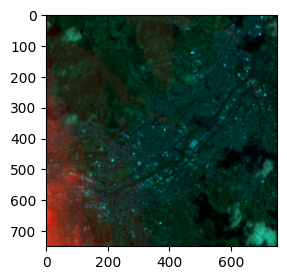

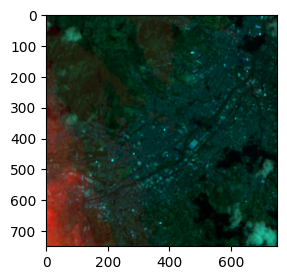

In [ ]:
images = sorted(glob.glob(os.path.join(aug_root)+"/*.tiff")) # use sorted to align images temporally back-forwards
for path in images[:3]:
    img = read_tiff(path, resize_ratio= resize_ratio, resizing = resizing, normalize=normalize, printing=printing)
    plt.figure(figsize=(9, 3))
    bands = [9,10,11]
    #print(img[:,:,1:4].shape)
    plt.imshow(img[:,:,bands])

In [ ]:
aug_path = os.path.join(aug_root, image_name)

In [ ]:
path

'/home/sebasmos/Desktop/DATASETS/DATASET_improved_10_cities/23001/image_2015-12-13.tiff'

In [ ]:
aug_path

'/home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001/23001/image_2015-12-13.tiff'

In [ ]:
aug_root

'/home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001'

1
